### Import Libraries

In [1]:
import gym
import gym.spaces
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

### Set Up GPUs

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Parameters

In [3]:
episodes = 3
gamma = 0.99 # specified by homework

# network parameters
learning_rate = 0.01
hidden_size = 20

# epochs 
epochs = 10000 # will be a lot on GPUs

### Policy Gradient Network

In [4]:
class PolicyGradient():
    def __init__(self, learning_rate=0.01, state_size=6400, action_size=2, hidden_size=20, name='PolicyGradient'):
        with tf.variable_scope(name):
            
            # Store Variables
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.actions_ = tf.placeholder(tf.int32, [None, action_size], name='actions')
            self.expected_future_rewards_ = tf.placeholder(tf.float32, [None,], name="expected_future_rewards")
            
            # Hidden Layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, action_size, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            
            # Output Layer
            self.action_distribution = tf.nn.softmax(self.fc3)
            
            # Training Section
            self.log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.fc3, labels = self.actions_)
            self.loss = tf.reduce_mean(self.log_prob * self.expected_future_rewards_)

            # Adjust Network
            self.learn = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

### Baseline Network

In [5]:
class Baseline():
    def __init__(self, learning_rate=0.01, state_size=6400, hidden_size=10, name="Baseline"):
        with tf.variable_scope(name):

            # Store Variables
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.expected_future_rewards_ = tf.placeholder(tf.float32, [None,], name="expected_future_rewards")

            # Hidden Layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, 1, activation_fn=None, 
                                                                 weights_initializer=tf.contrib.layers.xavier_initializer())

            # Define Loss
            self.loss = tf.reduce_mean(tf.square(self.fc3 - self.expected_future_rewards_), name="mse")

            # Adjust Network
            self.learn = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

### Predict Future Reward Function

In [6]:
def expected_rewards(episode_rewards):
    discounted_episode_rewards = np.zeros_like(episode_rewards)
    cumulative = 0.0
    for i in reversed(range(len(episode_rewards))):
        cumulative = cumulative * gamma + episode_rewards[i]
        discounted_episode_rewards[i] = cumulative
    
    mean = np.mean(discounted_episode_rewards)
    std = np.std(discounted_episode_rewards)
    discounted_episode_rewards = (discounted_episode_rewards - mean) / (std)
    
    return discounted_episode_rewards.tolist()

### Process Images

In [7]:
def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    return image.astype(np.float).ravel()

### Setup

In [8]:
tf.reset_default_graph()
network = PolicyGradient(name = 'pray4us', hidden_size=hidden_size, learning_rate=learning_rate)
baseline = Baseline(name = 'ughvariance', hidden_size=hidden_size, learning_rate=learning_rate)

In [9]:
# set up environment
env = gym.make('Pong-v0')

# Initialize the simulation
env.reset()

print('Environment Reset')

Environment Reset


### Training

In [12]:
# saver = tf.train.Saver()
all_rewards = []

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        
        # save all states, actions, and rewards that happen 
        episode_states, episode_actions, all_discount_rewards = [], [], []
        total_epoch_reward = 0
        running_rewards = []
        
        for ep in range(episodes):
            
            state = preprocess(env.reset())
            episode_rewards = []
            
            while True: 
            
                # get action prob distribution w.r.t. policy
                feed = {network.inputs_: state.reshape((1,*state.shape))}
                action_prob_dist = sess.run(network.action_distribution, feed_dict=feed)
                
                # select action w.r.t. distribution, only RIGHT & LEFT
                action = np.random.choice([2,3], p=action_prob_dist.ravel())
                new_state, reward, done, _ = env.step(action)
                
                # keep track of all states, actions, and rewards
                episode_states.append(state)
                episode_rewards.append(reward)
                
                # reformat action for softmax
                action_ = np.zeros(action_prob_dist.shape[1]) # 6 Pong has 6 action space
                action_[action - 2] = 1
                episode_actions.append(action_)
                
                # reset current state to be new state
                state = preprocess(new_state)
                
                if done:
                    # Calculate discounted reward per episode
                    exp_rewards = expected_rewards(episode_rewards)
                    all_discount_rewards += exp_rewards
                    
                    # reward per episode
                    running_rewards.append(sum(episode_rewards))
                    break
        
        # get baseline adjustment
        baseline_ = sess.run(baseline.fc3, feed_dict={baseline.inputs_ : np.vstack(episode_states)})
        exp_rewards_b = all_discount_rewards - np.hstack(baseline_)
        
        # train baseline network
        _, _= sess.run([baseline.loss, baseline.learn], 
                    feed_dict={baseline.inputs_: np.vstack(episode_states),
                    baseline.expected_future_rewards_: all_discount_rewards })
         
        # update Policy Gradient Network
        # if interested in seeing without baseline correction exp_rewards_b --> all_discount_rewards
        _, _= sess.run([network.loss, network.learn], 
                                     feed_dict={network.inputs_: np.vstack(episode_states),
                                     network.actions_: np.vstack(episode_actions),
                                     network.expected_future_rewards_: exp_rewards_b })      
        
        # average reward per episodes in epoch
        all_rewards.append(np.mean(running_rewards))
        
        print("########################")
        print("Epoch:", epoch, "Average Reward:", np.mean(running_rewards))

#         if (epoch % 100 == 0):
#             saver.save(sess, "checkpoints/cartpole{0}.ckpt".format(epoch))
            

########################
Epoch: 0 Average Reward: -20.0
########################
Epoch: 1 Average Reward: -21.0
########################
Epoch: 2 Average Reward: -21.0
########################
Epoch: 3 Average Reward: -21.0
########################
Epoch: 4 Average Reward: -21.0
########################
Epoch: 5 Average Reward: -19.0
########################
Epoch: 6 Average Reward: -21.0
########################
Epoch: 7 Average Reward: -18.0
########################
Epoch: 8 Average Reward: -21.0
########################
Epoch: 9 Average Reward: -20.0


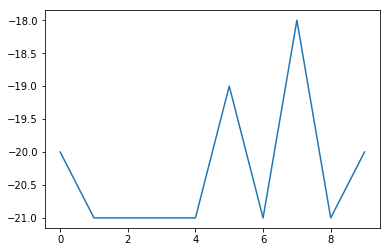

In [13]:
plt.plot(all_rewards)